In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
python3 = True

# 0 - Intruduction: usefull actions

The goal of this work is to build model able to predict probability for a client to leave ENEL (Churn)

## 0.1- Import of useful packages and modules

In [2]:
import pandas as pd, os, sys
pd.set_option('max_colwidth', None)
import itertools
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook
import seaborn as sns
import sklearn
import time
from pandas.core.common import flatten

## 0.2- Environment variables setting

In [3]:
# Setting environment variables
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")
if python3: os.environ['PYSPARK_PYTHON'] = "vsb/CI_conda_env_py3/bin/python"

## 0.2- Spark configuration 

In [4]:
# Importing the Spark Configurator and the Spark Session builder
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as spark_functions
import pyspark.sql.types as types
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.regression import GBTRegressor

# Stopping the current session if exists
try:
    session.stop()
except:
    print()
   
# Setting up the spark configurator  
conf = SparkConf()
conf.set('spark.serializer', "org.apache.spark.serializer.KryoSerializer")       
conf.set('spark.executor.memory', '64g')
conf.set('spark.driver.memory', '64g')
conf.set('spark.executor.cores', '3')
conf.set('spark.driver.cores', '3')
conf.set('spark.dynamicAllocation.enabled', 'true')
conf.set('spark.executor.instances', '4')
conf.set('spark.dynamicAllocation.minExecutors', '4')
conf.set('spark.dynamicAllocation.maxExecutors', '8')
conf.set('spark.executor.memoryOverhead', '8096')
conf.set('spark.driver.memoryOverhead', '8096')
conf.set('spark.driver.maxResultSize', '16g')
conf.set('spark.kryoserializer.buffer.max', '2047')
conf.setAppName('DA_Feature_Selection_Step2')
if python3: conf.set("spark.yarn.dist.archives", "/home/anxadvuser/anx_adv_achurn/env_conda_py3.zip#vsb")

# Creating the spark session object
session = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()

# Feature Selection Part 2 + Modeling

In [5]:
train_set = session.read.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_train_set_numeric")
train_set = train_set.na.drop()
test_set = session.read.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_test_set_numeric")
test_set = test_set.na.drop()

In [32]:
train_set.count()

10234327

In [33]:
test_set.count()

5163105

## Subsetting the data

Let's take a small subset(500 000 rows) of the train_set to accelerate the feature selection process

In [10]:
# add the column to be used to sample the data
train_set_for_sample = train_set.withColumn('sample_by_column', 
                                             spark_functions.concat(
                                                 spark_functions.col('val_t0_year'), 
                                                 spark_functions.col('val_t0_month'), 
                                                 spark_functions.col('val_churn_2_months')
                                             )
                                            )


# add the column to be used to drop eventual duplicates
train_set_for_sample = train_set_for_sample.withColumn("row_id", spark_functions.monotonically_increasing_id())

In [11]:
fractions = train_set_for_sample.select("sample_by_column").distinct().withColumn("fraction", spark_functions.lit(0.05)).rdd.collectAsMap()
print(fractions)

{'2019111.0': 0.05, '201961.0': 0.05, '202030.0': 0.05, '202040.0': 0.05, '201951.0': 0.05, '2019101.0': 0.05, '202050.0': 0.05, '202060.0': 0.05, '201971.0': 0.05, '202020.0': 0.05, '201960.0': 0.05, '201990.0': 0.05, '201950.0': 0.05, '2019120.0': 0.05, '202010.0': 0.05, '201981.0': 0.05, '2019121.0': 0.05, '202011.0': 0.05, '2019100.0': 0.05, '2019110.0': 0.05, '201970.0': 0.05, '201991.0': 0.05, '201980.0': 0.05}


In [12]:
seed = 10
train_set_subset = train_set_for_sample.stat.sampleBy("sample_by_column", fractions, seed)
train_set_subset = train_set_subset.dropDuplicates(['row_id'])

train_set_subset = train_set_subset.drop('sample_by_column')
train_set_subset = train_set_subset.drop('row_id')

In [13]:
train_set_subset.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+-----+
|val_t0_year|val_t0_month|val_churn_2_months|count|
+-----------+------------+------------------+-----+
|       2019|           5|               0.0|15886|
|       2019|           5|               1.0|27236|
|       2019|           6|               0.0|16203|
|       2019|           6|               1.0|28151|
|       2019|           7|               0.0|16231|
|       2019|           7|               1.0|23241|
|       2019|           8|               0.0|16356|
|       2019|           8|               1.0|21367|
|       2019|           9|               0.0|37025|
|       2019|           9|               1.0|48216|
|       2019|          10|               0.0|16486|
|       2019|          10|               1.0|33767|
|       2019|          11|               0.0|16408|
|       2019|          11|               1.0|31778|
|       2019|          12|               0.0|16571|
|       2019|          12|               1.0|27476|
|       2020

In [14]:
train_set_subset.count()

512415

In [15]:
#train_set_subset.write.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_train_set_numeric_subset")

In [5]:
train_set_subset = session.read.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_train_set_numeric_subset")

Let's make sure that all the features are numeric by checking the data types:

In [13]:
def count_column_types(spark_df):
    """Count number of columns per type"""
    return pd.DataFrame(spark_df.dtypes).groupby(1, as_index=False)[0].agg({'count':'count', 'names': lambda x: " | ".join(set(x))}).rename(columns={1:"type"})

In [14]:
count_column_types(train_set_subset)

type  count  \
0   bigint      4   
1   double    360   
2      int    334   
3   string      2   
4  tinyint    113   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Let's now have a look at the training data

In [15]:
train_set_subset.limit(10).toPandas().head(10)

idn_servizio_sk  idn_cliente_sk  fk_cliente_unico idc_id_key_servizio  \
0         19508988        16218834          10736086  02i0Y0000029S9YQAU   
1         49449248        18162198           1260921  02i0Y000005GY4HQAW   
2         47507583        16881476          13254721  02i0Y000004qUxFQAU   
3         58667503        18933474          11045469  02i1n00000N0IiOAAV   
4         62101694        16602959          10239363  02i1n00000QHRpAAAX   
5          7004871        16726595           8231168  02i0Y000001IVfhQAG   
6         10170349        16460154           1014262  02i0Y000001VthYQAS   
7         59335422        20220028          19326942  02i1n00000OfjIjAAJ   
8          8222143        16258104            368206  02i0Y000001NebvQAC   
9         65659928        16652676           8756333  02i1n00000RWPqPAAX   

   idn_sito_sk  idc_id_key_cliente  qta_eta_nrm  cdc_residente  \
0      3833306  0010Y00000F7LDTQA3            0              0   
1     32287739  0010Y00000FvH9mQAF           73              0   
2     34803118  0010Y00000FOHjcQAH            0              0   
3     39520780  0010Y00000U24dAQAR           66              0   
4     39710514  0010Y00000FHAZ7QAP            0              0   
5      5719829  0010Y00000FKJbsQAH            0              0   
6     14966409  0010Y00000FDVAtQAP            0              0   
7     39386519  0011n00001pK69wAAC           51              0   
8     26322508  0010Y00000F8N8MQAV            0              0   
9     29698491  0010Y00000FING2QAP           65              0   

   qta_indice_contattosita_ult_30gg  val_fascia_stress  ...  \
0                                 0                1.0  ...   
1                                 0                1.0  ...   
2                                 0                0.0  ...   
3                                 0                0.0  ...   
4                                 0                1.0  ...   
5                                 0                1.0  ...   
6                                 0                0.0  ...   
7                                 0                0.0  ...   
8                                 0                0.0  ...   
9                                 0                0.0  ...   

   xds_tipologia_azione_last_response_marketing_cli_embed1  \
0                                                 0.337737   
1                                                 0.337737   
2                                                 0.337737   
3                                                 0.337737   
4                                                 0.337737   
5                                                 0.337737   
6                                                 0.337737   
7                                                 0.337737   
8                                                 0.337737   
9                                                 0.337737   

   xds_tipologia_azione_last_response_marketing_cli_embed2  \
0                                                -0.357013   
1                                                -0.357013   
2                                                -0.357013   
3                                                -0.357013   
4                                                -0.357013   
5                                                -0.357013   
6                                                -0.357013   
7                                                -0.357013   
8                                                -0.357013   
9                                                -0.357013   

   xds_tipologia_azione_last_response_marketing_cli_embed3  \
0                                                -1.349892   
1                                                -1.349892   
2                                                -1.349892   
3                                                -1.349892   
4                                                -1.349892   
5      

In [16]:
print("Number of observations: "+ str(train_set_subset.count()))
print("Number of features: "+ str(len(train_set_subset.columns)))

Number of observations: 515718
Number of features: 813


## Functions implementation (get_assembled_data, unique selector, missing selector, collinear selector, low importance selector, ...)

In [9]:
"""
Feature selector for Machine Learning Modeling with PySpark. we implemented four selectors:
1. unique selector: identify the single unique features
2. missing selector: identify missing values features with missing threshold
3. collinear selector: identify collinear features with threshold
4. low importance selector: identify low importance features with Gradient Boosting Machine(GBM)
"""


missing_drop = []
unique_drop = []
corr_drop = []
total = None

def dtypes(df_in):
    """
    Generate the data type categories: numerical, categorical, date and unsupported category.
    :param df_in: the input rdd data frame
    :return: data type categories
    >>> test = spark.createDataFrame([
                        ('Joe', 67, 'F', 7000, 'asymptomatic', 286.1, '2019-6-28'),
                        ('Henry', 67, 'M', 8000, 'asymptomatic', 229.2, '2019-6-29'),
                        ('Sam', 37,  'F', 6000, 'nonanginal', 250.3, '2019-6-30'),
                        ('Max', 56, 'M', 9000, 'nontypical', 236.4, '2019-5-28'),
                        ('Mat', 56, 'F', 9000, 'asymptomatic', 254.5, '2019-4-28')],
                        ['Name', 'Age', 'Sex', 'Salary', 'ChestPain', 'Chol', 'CreatDate']
                       )
    >>> test = test.withColumn('CreatDate', spark_functions.col('CreatDate').cast('timestamp'))
    >>> from PySparkAudit import dtypes_class
    >>> dtypes_class(test)
    (     feature       DataType
    0       Name     StringType
    1        Age       LongType
    2        Sex     StringType
    3    Salary       LongType
    4  ChestPain     StringType
    5       Chol     DoubleType
    6  CreatDate  TimestampType,
    ['Age', 'Salary', 'Chol'],
    ['Name', 'Sex', 'ChestPain'],
    ['CreatDate'], [])
    """

    # all data types in pyspark (for reference)
    # __all__ = [
    # "DataType", "NullType", "StringType", "BinaryType", "BooleanType", "DateType",
    # "TimestampType", "DecimalType", "DoubleType", "FloatType", "ByteType", "IntegerType",
    # "LongType", "ShortType", "ArrayType", "MapType", "StructField", "StructType"]

    # numerical data types in rdd DataFrame dtypes
    num_types = ['DecimalType', 'DoubleType', 'FloatType', 'ByteType', 'IntegerType', 'LongType', 'ShortType']
    # qualitative data types in rdd DataFrame dtypes
    cat_types = ['NullType', 'StringType', 'BinaryType', 'BooleanType']
    # date data types in rdd DataFrame dtypes
    date_types = ['DateType', 'TimestampType']
    # unsupported data types in rdd DataFrame dtypes
    unsupported_types = ['ArrayType', 'MapType', 'StructField', 'StructType']

    all_fields = [(f.name, str(f.dataType)) for f in df_in.schema.fields]

    all_df = pd.DataFrame(all_fields, columns=['feature', 'DataType'])

    # initialize the memory for the corresponding fields
    num_fields = []
    cat_fields = []
    date_fields = []
    unsupported_fields = []

    [num_fields.append(item[0]) if item[1] in num_types else
     cat_fields.append(item[0]) if item[1] in cat_types else
     date_fields.append(item[0]) if item[1] in date_types else
     unsupported_fields.append(item[0]) for item in all_fields]

    return all_df, num_fields, cat_fields, date_fields, unsupported_fields


def get_encoded_names(df_in, categorical_cols):
    """
    get the encoded dummy variable names
    :param df_in: the input dataframe
    :param categorical_cols: the name list of the categorical columns
    :return: the name list of the encoded dummy variable for categorical columns
    """

    ind_names = [df_in.groupBy(c).count().sort(spark_functions.col("count").desc()).select(c).rdd.flatMap(lambda x: x).collect()
                 for c in categorical_cols]

    encodered_name = [categorical_cols[i] + '_' + j for i in range(len(categorical_cols)) for j in ind_names[i]]

    return encodered_name


def get_assembled_data(df_in, index_col=None, categorical_cols=None, continuous_cols=None, label_col=None, dropLast=False):
    """
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df_in: the dataframe
    :param categorical_cols: the name list of the categorical data
    :param continuous_cols:  the name list of the numerical data
    :param label_col:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: encoded dummy variable names and feature matrix
    >>> df = spark.createDataFrame([
                  (0, "a"),
                  (1, "b"),
                  (2, "c"),
                  (3, "a"),
                  (4, "a"),
                  (5, "c")
              ], ["id", "category"])
    >>> index_col = 'id'
    >>> categorical_cols = ['category']
    >>> continuous_cols = []
    >>> label_col = []
    >>> mat = get_assembled_data(df,index_col,categorical_cols,continuous_cols,label_col)
    >>> mat.show()
    >>>
        +---+-------------+
        | id|     features|
        +---+-------------+
        |  0|[1.0,0.0,0.0]|
        |  1|[0.0,0.0,1.0]|
        |  2|[0.0,1.0,0.0]|
        |  3|[1.0,0.0,0.0]|
        |  4|[1.0,0.0,0.0]|
        |  5|[0.0,1.0,0.0]|
        +---+-------------+
    """

    # exclude index col and label col
    excluded = list(flatten([index_col, label_col]))

    if continuous_cols:
        continuous_cols = [col for col in continuous_cols if col not in excluded]
    else:
        continuous_cols = []

    if categorical_cols:
        categorical_cols = [col for col in categorical_cols if col not in excluded]
    else:
        categorical_cols = []

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_cols]

    # default setting: dropLast=True
    encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                              outputCol="{0}_encoded".format(indexer.getOutputCol()), dropLast=dropLast)
                for indexer in indexers]

    assembler = VectorAssembler(inputCols=continuous_cols + [encoder.getOutputCol() for encoder in encoders],
                                outputCol="assembled_features")
    
    # Standard Scaler: 
    #We use the Standard Scaler to put all the numbers on the same scale, which is standard practice 
    #for machine learning. This takes the observation and subtracts the mean, and then divides that 
    #by the standard deviation.
    
    standardscaler = StandardScaler().setInputCol("assembled_features").setOutputCol("features")
    
    pipeline = Pipeline(stages=indexers + encoders + [assembler] + [standardscaler])

    encodered_col_names = get_encoded_names(df_in, categorical_cols)
    assembled_col_names = continuous_cols + encodered_col_names

    model = pipeline.fit(df_in)
    data = model.transform(df_in)

    if index_col and label_col:
        # for supervised learning
        data = data.withColumn('label', spark_functions.col(label_col))
        out_data = data.select(*list(flatten([index_col, 'features', 'label'])))
    elif not index_col and label_col:
        # for supervised learning
        data = data.withColumn('label', spark_functions.col(label_col))
        out_data = data.select('features', 'label')
    elif index_col and not label_col:
        # for unsupervised learning
        out_data = data.select(*list(flatten([index_col, 'features'])))
    elif not index_col and not label_col:
        # for unsupervised learning
        out_data = data.select('features')

    return assembled_col_names, out_data


def unique_selector(data, tracking=False):
    """
    Unique selector: identify the single unique features
    :param data: input dataframe
    :param tracking: the flag for displaying CPU time, the default value is False
    :return unique_drop: The name list of the single unique features
    """

    start = time.time()

    nunique = data.agg(*[spark_functions.countDistinct(c) for c in data.columns]).rdd.flatMap(lambda x: x).collect()

    unique_drop = list(np.array(data.columns)[np.array(nunique) == 1])

    end = time.time()

    if tracking:
        print('Unique selector took = ' + str(end - start) + ' s')

    return unique_drop


def missing_selector(data, missing_thold=0.6, display=False, tracking=False):
    """
    Missing selector: identify missing values features with missing threshold
    :param data: input dataframe
    :param missing_thold: threshold for missing values percentage
    :param display: the flag for displaying plots, the default value is False
    :param tracking: the flag for displaying CPU time, the default value is False
    :return: The name list of the missing values features above missing threshold
    """

    start = time.time()

    total = data.count()

    rate_missing = [data.filter((spark_functions.col(c).isNull()) | (spark_functions.trim(spark_functions.col(c)) == '')).count() / total
                    for c in data.columns]

    # self.rate_missing = rate_missing
    missing_drop = list(np.array(data.columns)[np.array(rate_missing) > missing_thold])

    end = time.time()

    if tracking:
        print('Missing selector took = ' + str(end - start) + ' s')

    if display:
        plt.figure(figsize=(10, 8))
        sns.distplot(rate_missing, bins=50, kde=False, rug=True, color='blue')
        plt.axvline(missing_thold, color='red', linestyle='--')
        plt.ylabel('Number of the features')
        plt.xlabel('Missing value percentage')
        plt.title('The missing value percentage Histogram')
        plt.show()

    return missing_drop


def corr_selector(data, index_col=None, label_col=None, corr_thold=0.9, method="pearson", rotation=True, display=False, tracking=False, cat_num=2):
    """
    collinear selector: identify collinear features with threshold
    :param data: input dataframe
    :param index_col: the name of the index column and the other columns you want to exclude
    :param label_col: the name of the label column
    :param corr_thold: threshold for collinear scores
    :param method: the method to use for computing correlation, supported: pearson (default), spearman
    :param rotation: the flag of rotate x-ticks
    :param display: the flag for displaying plots, the default value is False
    :param tracking: the flag for displaying CPU time, the default value is False
    :param cat_num: the number of the categorical feature (helping removing binary features)
    :return: The name list of the correlated values features above threshold
    """
    start = time.time()
    
    # numerical data types in rdd DataFrame dtypes
    num_types = ['DecimalType', 'DoubleType', 'FloatType',
                 'ByteType', 'IntegerType', 'LongType', 'ShortType']
    
    num_fields = [f.name for f in data.schema.fields if str(f.dataType) in num_types]
    
    #nunique = data.agg(*[spark_functions.countDistinct(c) for c in data.columns]).rdd.flatMap(lambda x: x).collect()
    
    #flag = list(np.array(data.columns)[np.array(nunique) <= cat_num])

    # exclude index and label cols
    if index_col or label_col:
        if not isinstance(index_col, list):
            index_col = [index_col]
        excluded = list(dict.fromkeys(index_col + [label_col]))
    else:
        excluded = []

    num_cols = [col for col in num_fields if col not in excluded]

    if len(num_cols) > 1:
        data = data.select(num_cols).na.drop()
    else:
        print("Only has one numerical feature!!! Don't need correlation selector.")
        exit(0)
    
    # fill nan with 0
    df_in = data.fillna(0)

    # convert the rdd data data frame to dense matrix
    col_names = df_in.columns
    print('Converting the rdd data frame to dense matrix ...')
    features = df_in.rdd.map(lambda row: row[0:])

    # calculate the correlation matrix
    print('Computing the correlation matrix ...')
    corr_mat = Statistics.corr(features, method=method)
    corr = pd.DataFrame(corr_mat)
    corr.index, corr.columns = col_names, col_names

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

    corr_drop = [column for column in upper.columns if any(upper[column].abs() > corr_thold)]

    end = time.time()

    if tracking:
        print('Correlation selector took = ' + str(end - start) + ' s')

    if display and corr_drop:
        dropped = corr[corr_drop]
        fig = plt.figure(figsize=(60, 60))  # Push new figure on stack
        sns_plot = sns.heatmap(dropped, cmap="YlGnBu",
                               xticklabels=dropped.columns.values,
                               yticklabels=corr.columns.values,
                               annot=True, fmt=".1g", linewidths=.25)
        plt.xlabel('Features to Drop', size=20)
        plt.ylabel('All Numerical Features', size=20)
        plt.title("Correlations Above Threshold {}".format(corr_thold), fontsize=20)
        if rotation:
            plt.xticks(rotation=90, fontsize=20)
            sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=0, fontsize=20)
        plt.show()

    return corr_drop


def importance_selector(data, index_col, label_col, task, importance_thold=None, cumulative_thold=0.96, n_train=5, top_n=20, 
                        dropLast=False, display=False, tracking=False):
    """
    importance selector: identify low feature importance features with threshold
    :param data: input dataframe
    :param index_col: the name of the index column and the other columns you want to exclude
    :param label_col: the name of the label column
    :param task: the ensemble model type, supported task "classification" or "regression"
    :param importance_thold: the threshold of the feature importance if missing will be auto calculated by the
           cumulative threshold
    :param cumulative_thold: the threshold of the cumulative feature importance, this will be used to determine
           the importance_thold when importance_thold is missing
    :param missing_thold: threshold for missing values percentage
    :param corr_thold: threshold for collinear scores
    :param method: the method to use for computing correlation, supported: pearson (default), spearman
    :param rotation: the flag of rotate x-ticks
    :param n_train: the numbers of train for average the feature importance
    :param top_n: the numbers for plot top_n highest feature importance
    :param dropLast: the flag of the drop last column during applying the OneHotEncoder
    :param display: the flag for displaying plots, the default value is False
    :param tracking: the flag for displaying CPU time, the default value is False
    :return: The name list of the dropped features with low feature importance
    """

    start = time.time()
    
    data = data.fillna(0)
    data = data.na.fill('null')

    _, continuous_cols, categorical_cols, _, _ = dtypes(data)
    assembled_col_names, assembled_data = get_assembled_data(data, index_col, categorical_cols, continuous_cols, label_col, dropLast)
    
    print('Preparing GBT model ...')
    if task == 'classification':
        #labelIndexer = StringIndexer(inputCol='label', outputCol='label_indexed')
        alg = GBTClassifier(labelCol='label', featuresCol="features", maxIter=50)
        pipeline_model = Pipeline(stages=[alg])
    elif task == 'regression':
        alg = GBTRegressor(labelCol='label',
                           featuresCol="features", maxIter=50)
        pipeline_model = Pipeline(stages=[alg])
    else:
        raise ValueError('Supported task "classification" or "regression"')

    # init feature importance
    feature_importance = np.zeros(len(assembled_col_names))
    
    print('Training GBT model...')
    for _ in range(n_train):
        
        print("Stage "+ str(_)+ " ...")
        (trainingData, _) = assembled_data.randomSplit([0.6, 0.4], seed=None)
        model = pipeline_model.fit(trainingData)

        if task == 'classification':
            importances = model.stages[0].featureImportances
        elif task == 'regression':
            importances = model.stages[0].featureImportances

        feature_importance += [a / n_train for a in importances]

    d = {'feature': assembled_col_names,
         'avg_importance': [a for a in feature_importance]}

    feature_importances = pd.DataFrame(d).sort_values('avg_importance', ascending=False)
    feature_importances['cumulative_importance'] = feature_importances['avg_importance'].cumsum()
    feature_importances = feature_importances.reset_index(drop=True)

    # set a flag to record whether we need plot cumulative importance
    plt_flag = False
    if not importance_thold:
        plt_flag = True # if we use the cumulative importance to determine the importance, we will plot
        importance_thold = feature_importances['avg_importance'][np.max(np.where(
                                     feature_importances['cumulative_importance'] < cumulative_thold))]

    # numerical cols to be dropped (with importance lower than threshold)
    dropped_num = [assembled_col_names[i] for i in range(len(assembled_col_names))
                   if [a < importance_thold for a in feature_importance][i] and assembled_col_names[i] in continuous_cols]
    
    # dummy names with importance higher than threshold
    keeped_dummy = ['_'.join(assembled_col_names[i].split('_')[:-1]) for i in range(len(assembled_col_names))
                    if [a > importance_thold for a in feature_importance][i]
                    and assembled_col_names[i] not in continuous_cols]
    
    # dummy names with importance lower than threshold
    dropped_dummy = ['_'.join(assembled_col_names[i].split('_')[:-1]) for i in range(len(assembled_col_names))
                     if [a <= importance_thold for a in feature_importance][i]
                     and assembled_col_names[i] not in continuous_cols]

    # categorical cols to be dropped (not the dummy names).
    dropped_cat = [a for a in list(dict.fromkeys(dropped_dummy))
                   if (a not in list(dict.fromkeys(keeped_dummy)) and a in categorical_cols)]

    imp_drop = list(dict.fromkeys(dropped_num + dropped_cat))

    end = time.time()

    if tracking:
        print('All importance selector took = ' + str(end - start) + ' s')

    if display:
        if plt_flag:
            # plot the threshold of the cumulative importance
            plt.figure(figsize=(10, 8))
            ax = sns.lineplot(x=range(1, len(feature_importances) + 1), y="cumulative_importance",
                              data=feature_importances, color='blue')

            cat_point = np.max(np.where(feature_importances['cumulative_importance'] < cumulative_thold))
            # plt.axhline(i_thre, ls='--')
            plt.text(cat_point + 5, cumulative_thold, (cat_point, cumulative_thold), color='red')
            plt.axvline(cat_point, color='red', linestyle='--')
            plt.xlabel('Number of the features')
            plt.show()

        # plot top_n feature importance
        plt.figure(figsize=(40, 15))
        plt_data = feature_importances[:top_n]
        ax = sns.barplot(x='avg_importance', y='feature', data=plt_data)
        ax.set_xlabel('avg_importance')
        plt.title("Top {} feature importance ".format(top_n), fontsize=20)
        plt.show()

    return imp_drop, feature_importances

In [7]:
# get_assembled_data test - this function is used to have the data in the correct form to apply any pyspark model
indexCols = ['fk_cliente_unico', 'idn_servizio_sk', 'idc_id_key_cliente', 'idc_id_key_servizio']
labelCol = 'val_churn_2_months'
_, continuous_cols, categorical_cols, _, _ = dtypes(train_set_subset)

assembled_col_names, assembled_data = get_assembled_data(train_set_subset, index_col = indexCols, categorical_cols = categorical_cols, 
                                                         continuous_cols = continuous_cols, label_col = labelCol)

print(len(assembled_col_names))
assembled_data.show()

808
+----------------+---------------+------------------+-------------------+--------------------+-----+
|fk_cliente_unico|idn_servizio_sk|idc_id_key_cliente|idc_id_key_servizio|            features|label|
+----------------+---------------+------------------+-------------------+--------------------+-----+
|        10736086|       19508988|0010Y00000F7LDTQA3| 02i0Y0000029S9YQAU|(808,[0,1,5,21,29...|  1.0|
|         1260921|       49449248|0010Y00000FvH9mQAF| 02i0Y000005GY4HQAW|(808,[0,1,2,5,21,...|  0.0|
|        13254721|       47507583|0010Y00000FOHjcQAH| 02i0Y000004qUxFQAU|(808,[0,1,6,7,9,1...|  1.0|
|        11045469|       58667503|0010Y00000U24dAQAR| 02i1n00000N0IiOAAV|(808,[0,1,2,6,7,9...|  0.0|
|        10239363|       62101694|0010Y00000FHAZ7QAP| 02i1n00000QHRpAAAX|(808,[0,1,5,21,29...|  1.0|
|         8231168|        7004871|0010Y00000FKJbsQAH| 02i0Y000001IVfhQAG|(808,[0,1,5,6,7,8...|  1.0|
|         1014262|       10170349|0010Y00000FDVAtQAP| 02i0Y000001VthYQAS|(808,[0,1,29,3

## Feature selection using previously implemented functions

In [7]:
# These columns were kept because they identify the entity whose churn is to be predicted
indexCols = ['fk_cliente_unico', 'idn_servizio_sk', 'idc_id_key_cliente', 'idc_id_key_servizio']
labelCol = 'val_churn_2_months'
task = 'classification'

### Unique Selector

In [23]:
print('unique_selector: returns all columns having only one unique value')
unique_selector_to_be_dropped_cols = unique_selector(train_set_subset, tracking=True)
print(len(unique_selector_to_be_dropped_cols))

unique_selector: returns all columns having only one unique value
Unique selector took = 1879.7252604961395 s
7


In [9]:
#unique_selector_to_be_dropped_cols = ['qta_cnt_mds_specifica_visualizzazione_area_clienti_m1', 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m3', 
#                                      'qta_cnt_mds_specifica_visualizzazione_area_clienti_m6', 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m9',
#                                      'qta_cnt_mds_tipologia_attivita_gestione_notifiche_m6', 'qta_cnt_attivita_bye_bye_letter_last_3_months',
#                                      'cdc_id_mercato_INDIRIZZO_FORNITURA']
#train_set_subset_missing = train_set_subset.drop(*unique_selector_to_be_dropped_cols)
#missing_selector_to_be_dropped_cols = []

In [10]:
unique_selector_to_be_dropped_cols

['qta_cnt_mds_specifica_visualizzazione_area_clienti_m1',
 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m3',
 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m6',
 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m9',
 'qta_cnt_mds_tipologia_attivita_gestione_notifiche_m6',
 'qta_cnt_attivita_bye_bye_letter_last_3_months',
 'cdc_id_mercato_INDIRIZZO_FORNITURA']

### Missing Selector

missing_selector: returns all columns having missing proportion above a given threshold
Missing selector took = 4128.601825714111 s


<IPython.core.display.Javascript object>


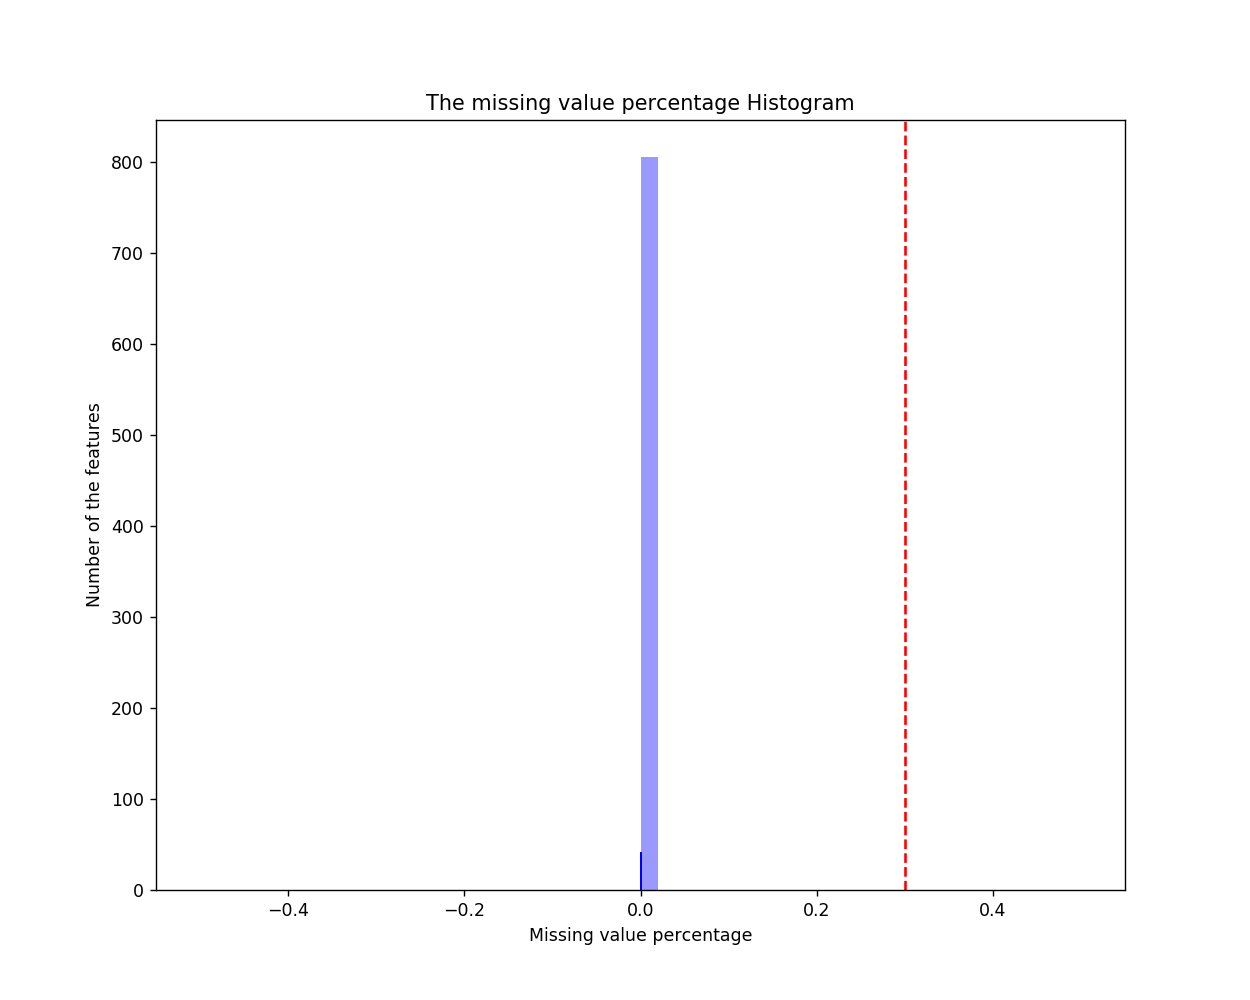

0


In [27]:
print('missing_selector: returns all columns having missing proportion above a given threshold')

train_set_subset_missing = train_set_subset.drop(*unique_selector_to_be_dropped_cols)

missing_selector_to_be_dropped_cols = missing_selector(train_set_subset_missing, missing_thold=0.3, display=True, tracking=True)
print(len(missing_selector_to_be_dropped_cols))

In [11]:
missing_selector_to_be_dropped_cols

[]

### Importance Selector

importance_selector: returns the columns to be dropped based on GBT feature impotance and a given threshold
Preparing GBT model ...
Training GBT model...
Stage 0 ...
Stage 1 ...
Stage 2 ...
Stage 3 ...
Stage 4 ...
All importance selector took = 1750.4415502548218 s


<IPython.core.display.Javascript object>


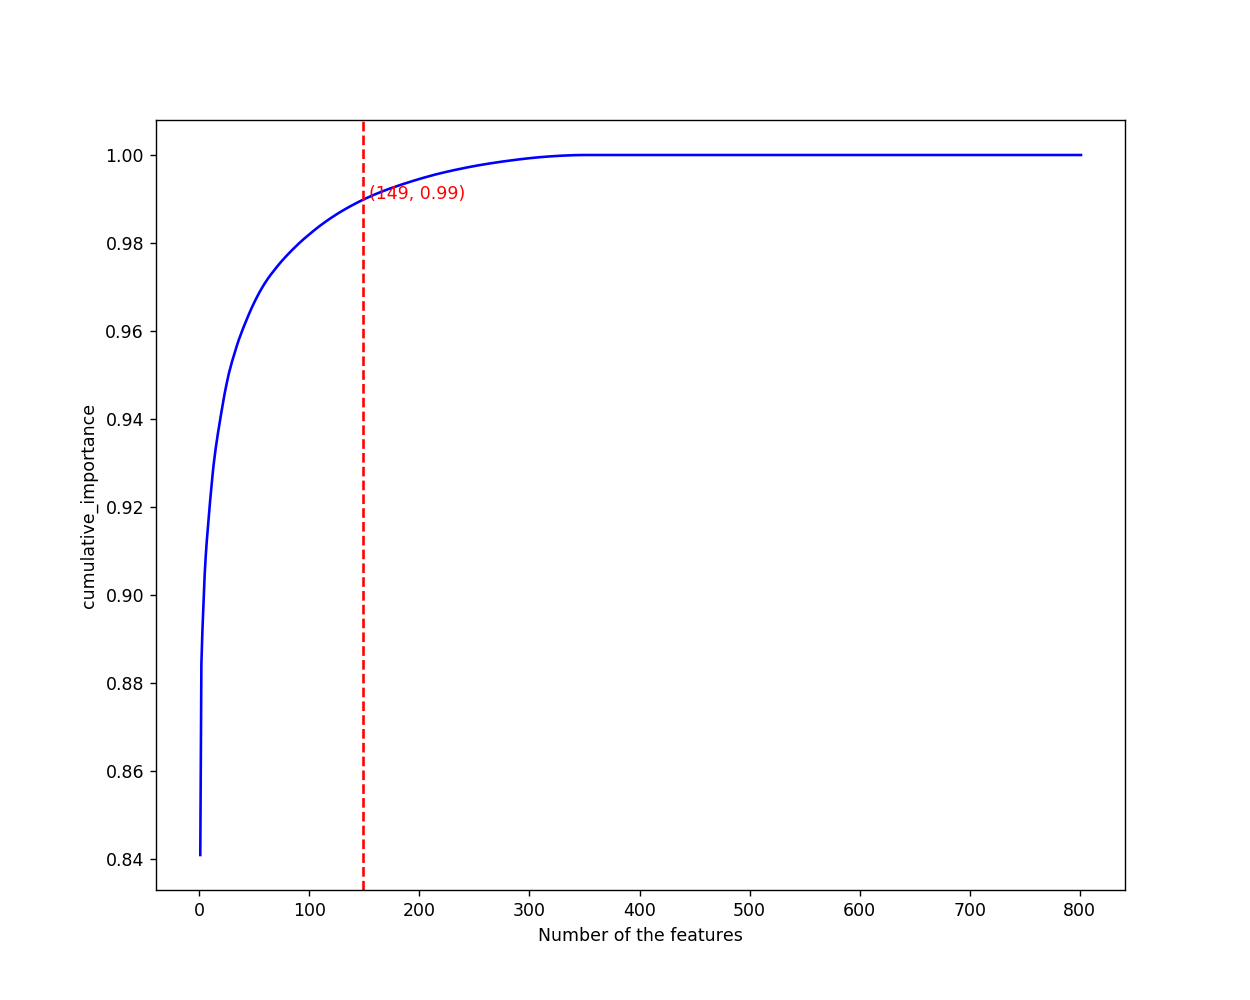

<IPython.core.display.Javascript object>

651


In [12]:
# importance threshold is determined by importance_thold or cumulative_thold. If importance_thold is missing then
# the importance_thold will be calculated based on cumulative_thold
print('importance_selector: returns the columns to be dropped based on GBT feature impotance and a given threshold')

train_set_subset_importance = train_set_subset_missing.drop(*missing_selector_to_be_dropped_cols)

importance_selector_to_be_dropped_cols, feature_importances = importance_selector(train_set_subset_importance, index_col=indexCols, label_col=labelCol, task = 'classification', 
                                                             importance_thold=None, cumulative_thold=0.99, n_train=5, top_n=50, dropLast=False, display=True, tracking=True)
print(len(importance_selector_to_be_dropped_cols))

In [14]:
importance_selector_to_be_dropped_cols

['cdc_residente',
 'val_paga_ritardo_mean_ciclo_last_6_months',
 'val_paga_ritardo_min_ciclo_last_6_months',
 'val_paga_ritardo_sum_ciclo_last_6_months',
 'qta_paga_ritardo_ciclo_last_6_months',
 'val_paga_ritardo_max_ciclo_last_1_months',
 'val_paga_ritardo_mean_ciclo_last_1_months',
 'val_paga_ritardo_min_ciclo_last_1_months',
 'val_paga_ritardo_sum_ciclo_last_1_months',
 'qta_paga_ritardo_ciclo_last_1_months',
 'fln_player_forte',
 'fln_player_forte_win_back',
 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m1',
 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m3',
 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m6',
 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m9',
 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m12',
 'fln_prima_meta',
 'fln_rischio_Baby_Churn',
 'fln_rischio_Pre_Rinnovo',
 'val_perc_Abitazioni_Residenti',
 'val_perc_Abitazioni_Vuote',
 'val_perc_Altri_Tipi_Alloggio',
 'val_perc_Abitazioni_Non_Residenti',
 'val_perc_Famiglie_Alloggio_Affitto'

### Correlation Selector 

In [21]:
print('corr_selector: identify collinear features given a threshold')

train_set_subset_corr = train_set_subset_importance.drop(*importance_selector_to_be_dropped_cols)

corr_selector_to_be_dropped_cols = corr_selector(train_set_subset_corr, index_col=indexCols, label_col=labelCol, corr_thold=0.9, method="pearson", 
                                                 rotation=True, display=True, tracking=True, cat_num=1)
print(len(corr_selector_to_be_dropped_cols))

corr_selector: identify collinear features given a threshold
Converting the rdd data frame to dense matrix ...
Computing the correlation matrix ...
Correlation selector took = 12.967080354690552 s


<IPython.core.display.Javascript object>

24


In [22]:
corr_selector_to_be_dropped_cols

['val_paga_ritardo_mean_ciclo_last_3_months',
 'val_paga_ritardo_sum_ciclo_last_3_months',
 'qta_numero_fattura_count_ciclo_last_12_months',
 'qta_cnt_mds_tipologia_attivita_other_m6',
 'val_consumi_x_min_over_mean_ciclo_ele_last_6_months',
 'val_importo_addebito_x_min_ciclo_ele_last_3_months',
 'qta_cnt_contatti_outbound_all_channel_m9',
 'qta_cnt_contatti_outbound_all_channel_m12',
 'qta_cnt_macrocausale_Problemi_in_fase_di_attivazione_last_90_days',
 'val_mean_fattura_pagata_non_totalmente_servizio_last_6_months_canale_ALL',
 'qta_cnt_fattura_pagata_non_totalmente_servizio_last_6_months_canale_ALL',
 'val_mean_days_emissione_fattura_pagamento_servizio_last_3_months_canale_ALL',
 'val_mean_days_scadenza_fattura_pagamento_servizio_last_3_months_canale_ALL',
 'val_mean_fattura_non_pagata_servizio_last_3_months_canale_ALL',
 'qta_max_days_scadenza_fattura_pagamento_servizio_last_3_months_canale_ALL',
 'cdc_tenure_bucket_cliente',
 'qta_cnt_distacchi_last_2_months',
 'lds_prodotto_listin

### Gather all the columns to be dropped

In [6]:
to_be_dropped_cols = ['cdc_id_mercato_LIBERO', 'cdc_Comune_Montano', 'sds_regione_embed6', 'mds_nome_campagna_last_response_marketing_cli_embed2', 'val_totale_pagare_x_max_ciclo_gas_last_3_months', 'fln_cliente_response_negativa_last_3_months', 'mds_sottocanale_embed3', 'val_totale_pagare_x_mean_ciclo_ele_last_1_months', 'qta_cnt_microcausale_PIANO_DI_RIENTRO_last_90_days', 'fln_distributore_gas_comune_2i_Rete_Gas_SpA', 'sds_regione_embed10', 'sds_provincia_embed9', 'cdc_cap_nrm_embed3', 'val_totale_pagare_x_min_over_mean_ciclo_gas_last_1_months', 'val_consumi_x_min_over_mean_ciclo_gas_last_3_months', 'val_consumi_x_mean_ciclo_gas_last_6_months', 'fln_venditore_mercato_libero_gas_comune_ENEGAN', 'fln_player_forte', 'val_consumi_x_mean_ciclo_gas_last_3_months', 'qta_cnt_attivita_dati_catastali_last_3_months', 'val_potenza_contrattuale', 'fln_fattura_pagata_totalmente_in_ritardo_servizio_last_6_months_canale_ALL', 'fln_venditore_mercato_libero_gas_comune_AIMAG', 'val_Negozi_Compr_Mean', 'sds_cluster_gas', 'fln_fattura_non_pagata_servizio_last_6_months_canale_ALL', 'val_POT_TOTALE', 'sds_cluster_ele', 'qta_cnt_mds_tipologia_attivita_other_m3', 'fln_comunicazione_rinnovo_last_1_months_sottocanale_PEC', 'val_importo_addebito_x_sum_ciclo_ele_last_1_months', 'qta_days_since_last_inbound_contact_microcausale_AUTOLETTURA', 'cdc_cap_nrm_embed2', 'val_pop_res_totale_15_anni_e_piu_casalinghe', 'cdc_istat_embed6', 'mds_canale_acquisizione_embed4', 'qta_paga_ritardo_ciclo_last_1_months', 'cdc_cap_nrm_embed7', 'fln_venditore_mercato_libero_gas_comune_Dolomiti_Energia', 'val_importo_addebito_x_mean_ciclo_gas_last_6_months', 'val_paga_ritardo_mean_ciclo_last_3_months', 'val_mean_fattura_pagata_totalmente_nei_tempi_servizio_last_6_months_canale_ALL', 'val_Idx_Commercio', 'fln_distributore_energia_comune_A2A', 'xds_tipologia_azione_last_response_marketing_cli_embed6', 'qta_days_since_last_inbound_contact_channel_CHAT', 'val_Residenti', 'qta_cnt_microcausale_RECLAMI_SCRITTI_last_90_days', 'mds_sottocanale_embed2', 'fln_venditore_mercato_libero_ele_comune_Axpo_Group', 'qta_cnt_canale_CHAT_last_90_days', 'val_totale_pagare_x_sum_ciclo_gas_last_6_months', 'val_pop_res_totale_che_si_sposta_giornalmente_nel_comune_dimora_abituale', 'qta_days_since_last_inbound_contact_channel_DOCUMENTALE', 'fln_fattura_pagata_non_totalmente_servizio_last_6_months_canale_ALL', 'val_importo_addebito_x_sum_ciclo_ele_last_3_months', 'val_totale_pagare_x_max_over_mean_ciclo_ele_last_3_months', 'val_importo_addebito_x_min_ciclo_gas_last_3_months', 'sds_regione_fatturazione_embed7', 'fln_primo_contatto_inbound', 'xds_tipologia_azione_last_response_marketing_cli_embed10', 'qta_cnt_cliente_response_negativa_last_3_months', 'qta_numero_fattura_count_ciclo_last_12_months', 'val_importo_addebito_x_max_over_mean_ciclo_gas_last_3_months', 'xds_tipologia_azione_last_response_marketing_cli_embed2', 'fln_venditore_mercato_libero_ele_comune_Alperia', 'qta_cnt_fln_contatti_inbound_reclamo_m12', 'fln_venditore_mercato_libero_gas_comune_Green_Network', 'fln_criticita_cross_last_90_days', 'mds_sottocanale_embed9', 'xds_tipologia_azione_last_response_marketing_cli_embed4', 'qta_cnt_attivita_invio_WL_pesante_last_3_months', 'xds_tipologia_azione_last_response_marketing_cli_embed9', 'sds_regione_embed2', 'qta_numero_fattura_count_ciclo_last_3_months', 'qta_cnt_attivita_blacklist_last_3_months', 'qta_cnt_competitor_forti_enel_venditore_mercato_libero_ele', 'val_importo_addebito_x_max_ciclo_gas_last_1_months', 'lds_tipo_uso_embed9', 'qta_cnt_fln_contatti_inbound_autolet_m3', 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m6', 'xds_canale_last_response_marketing_cli_embed8', 'cdc_cv_fasce_servizio', 'val_importo_addebito_x_mean_ciclo_gas_last_3_months', 'mds_nome_campagna_last_response_marketing_cli_embed10', 'val_importo_addebito_x_last_ciclo', 'fln_distributore_energia_comune_HERA', 'cdc_istat_embed7', 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m1', 'qta_numero_fattura_count_ciclo_last_9_months', 'qta_cnt_mds_tipologia_attivita_gestione_comunicazioni_m3', 'fln_venditore_mercato_libero_ele_comune_IREN', 'qta_cnt_contatti_inbound_all_channel_m6', 'fln_venditore_mercato_libero_gas_comune_METANO_NORD_SPA', 'cdc_cluster_fattura_last_OTHER', 'cdc_istat_embed2', 'cdc_causale_attivazione_embed2', 'val_mean_fattura_non_pagata_servizio_last_3_months_canale_ALL', 'qta_days_since_last_inbound_contact_microcausale_PIANO_DI_RIENTRO', 'val_mean_fattura_pagata_totalmente_in_ritardo_servizio_last_3_months_canale_ALL', 'qta_cnt_microcausale_INFORMATIVA_NON_DI_COMPETENZA_last_90_days', 'qta_cnt_competitor_forti_enel_venditore_mercato_libero_gas', 'qta_cnt_microcausale_AUTOLETTURA_last_90_days', 'qta_days_since_last_inbound_contact_macrocausale_Chiarimento_su_offerta', 'mds_nome_campagna_last_response_marketing_cli_embed8', 'val_consumi_x_min_over_mean_ciclo_ele_last_6_months', 'xds_tipologia_azione_last_response_marketing_cli_embed8', 'lds_comune_fornitura_embed6', 'lds_prodotto_listino_2_embed9', 'val_importo_addebito_x_mean_ciclo_ele_last_6_months', 'fln_venditore_mercato_libero_gas_comune_ENI', 'xds_canale_last_response_marketing_cli_embed5', 'fln_venditore_mercato_libero_ele_comune_Dolomiti_Energia', 'lds_societa_vendita_embed4', 'mds_nome_campagna_last_response_marketing_cli_embed6', 'qta_cnt_fln_contatti_inbound_m6', 'qta_cnt_canale_WEB_last_90_days', 'val_consumi_x_mean_ciclo_ele_last_1_months', 'qta_cnt_mds_tipologia_attivita_gestione_clienti_m1', 'xds_canale_last_response_marketing_cli_embed7', 'val_totale_pagare_x_sum_ciclo_ele_last_3_months', 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m9', 'val_paga_ritardo_min_ciclo_last_1_months', 'fln_cliente_response_positiva_last_3_months', 'lds_tipo_uso_embed6', 'sds_regione_fatturazione_embed9', 'qta_days_since_last_inbound_contact_microcausale_RECLAMI_SCRITTI', 'cdc_istat_embed4', 'val_importo_addebito_x_mean_ciclo_ele_last_1_months', 'fln_venditore_mercato_libero_ele_comune_Gruppo_Canarbino', 'sds_regione_embed3', 'qta_giorni_ultimo_contatto_inbound', 'sds_regione_fatturazione_embed4', 'qta_cnt_mds_specifica_disdetta_m12', 'val_importo_addebito_x_max_ciclo_gas_last_6_months', 'qta_cnt_mds_tipologia_attivita_gestione_clienti_m3', 'val_importo_addebito_x_last', 'qta_cnt_mds_tipologia_attivita_gestione_consumi_m12', 'fln_dual', 'val_totale_pagare_x_max_over_mean_ciclo_ele_last_1_months', 'qta_cnt_sollecito_cartaceo_cli', 'sds_mat_fatturazione_NORD_OVEST', 'fln_sollecito_last_2_months_cli', 'qta_cnt_attivita_posta_documenti_last_3_months', 'qta_days_since_last_inbound_contact_microcausale_INFORMATIVA_CONSUMI_PAGAMENTI', 'val_consumi_x_max_ciclo_ele_last_3_months', 'sds_mat_fatturazione_NORD_EST', 'qta_days_since_last_inbound_contact_microcausale_ALLACCIO_E_ATTIVAZIONE', 'sds_regione_embed9', 'qta_days_since_last_inbound_contact_channel_DOCUMENTALE_COMPLESSO', 'qta_days_since_last_inbound_contact_microcausale_COPIA_DOCUMENTAZIONI', 'lds_tipo_uso_embed7', 'lds_comune_fornitura_embed5', 'val_mean_fattura_pagata_non_totalmente_servizio_last_6_months_canale_ALL', 'val_totale_pagare_x_min_over_mean_ciclo_ele_last_1_months', 'cdc_cap_nrm_embed1', 'val_consumi_x_min_over_mean_ciclo_ele_last_3_months', 'val_consumi_x_min_ciclo_ele_last_6_months', 'fln_venditore_mercato_libero_ele_comune_ENGIE', 'qta_cnt_diffida_procedura_M1_cli', 'sds_provincia_fatturazione_embed7', 'fln_venditore_mercato_libero_gas_only_small', 'val_totale_pagare_x_mean_ciclo_ele_last_3_months', 'fln_cliente_con_response_marketing_utile_last_3_months', 'val_delta_prezzo_percentuale_ele_last_1_months', 'qta_cnt_attivita_dl_piano_casa_last_3_months', 'qta_days_since_last_inbound_contact_macrocausale_Esecuzione_lavori', 'val_consumi_x_max_over_mean_ciclo_gas_last_6_months', 'lds_societa_vendita_embed8', 'val_POT_POWER_NETTO', 'val_mean_val_fattura_non_pagato_servizio_last_6_months_canale_ALL', 'qta_cnt_mds_specifica_adesione_m1', 'fln_rischio_Pre_Rinnovo', 'cdc_stato_servizio_calc_SOSPESO_ICT', 'qta_cnt_fln_contatti_inbound_m1', 'fln_venditore_mercato_libero_ele_comune_ENI', 'mds_tipologia_pagamento_BONIFICO', 'fln_venditore_mercato_libero_ele_enel', 'val_totale_pagare_x_mean_ciclo_gas_last_6_months', 'qta_cnt_microcausale_LAVORI_E_MODIFICHE_TECNICHE_POTENZA_TENSIONE_last_90_days', 'cdc_causale_attivazione_embed6', 'val_totale_pagare_x_mean_ciclo_gas_last_1_months', 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m3', 'xds_canale_last_response_marketing_cli_embed1', 'val_totale_pagare_x_min_over_mean_ciclo_gas_last_3_months', 'val_consumi_x_max_over_mean_ciclo_gas_last_3_months', 'qta_cnt_contatti_outbound_all_channel_m9', 'qta_cnt_distacchi_last_2_months', 'cdc_stato_servizio_calc_RIDOTTO', 'val_rimborsi_mean_ciclo_last_3_months', 'fln_rinnovo_last_1_months_tipologia_RVC', 'qta_cnt_macrocausale_Chiarimenti_su_fatture_last_90_days', 'fln_venditore_mercato_libero_gas_comune_ENGIE', 'val_totale_pagare_x_sum_ciclo_gas_last_1_months', 'val_importo_addebito_x_min_over_mean_ciclo_gas_last_3_months', 'qta_cnt_macrocausale_Chiarimento_su_offerta_last_90_days', 'cdc_residente', 'fln_venditore_mercato_libero_ele_comune_ENEGAN', 'val_importo_addebito_x_sum_ciclo_gas_last_6_months', 'qta_cnt_microcausale_RETTIFICHE_CONSUMI_FATTURAZIONE_last_90_days', 'qta_cnt_mds_tipologia_attivita_gestione_credito_m12', 'qta_cnt_mds_tipologia_attivita_gestione_notifiche_m9', 'fln_cliente_response_competitor_last_3_months', 'sds_provincia_fatturazione_embed8', 'val_totale_pagare_x_min_ciclo_gas_last_1_months', 'fln_distributore_gas_big', 'qta_cnt_mds_specifica_adesione_m12', 'qta_cnt_solleciti_livello_01_cli', 'qta_days_since_last_inbound_contact_microcausale_INFORMATIVA', 'qta_cnt_mds_tipologia_attivita_gestione_bolletta_m3', 'qta_cnt_mds_tipologia_attivita_gestione_consumi_m1', 'val_consumi_x_max_over_mean_ciclo_ele_last_3_months', 'val_totale_pagare_x_max_ciclo_ele_last_6_months', 'cdc_cap_nrm_embed6', 'sds_mat_NORD_EST', 'xds_tipologia_azione_last_response_marketing_cli_embed1', 'qta_max_days_scadenza_fattura_pagamento_servizio_last_3_months_canale_ALL', 'fln_distributore_energia_big', 'sds_regione_fatturazione_embed6', 'qta_cnt_fln_chiamate_inbound_m9', 'lds_societa_vendita_embed6', 'fln_bolletta_web_attiva', 'val_totale_pagare_x_max_ciclo_ele_last_3_months', 'val_importo_addebito_x_max_over_mean_ciclo_gas_last_6_months', 'fln_multi_venditori_mercato_libero_gas_comune', 'qta_days_since_last_inbound_contact_microcausale_VOLTURA', 'qta_cnt_fln_contatti_inbound_guasti_m9', 'cdc_istat_embed8', 'val_perc_Abitazioni_Vuote', 'qta_cnt_fln_contatti_inbound_autolet_m9', 'xds_canale_last_response_marketing_cli_embed4', 'xds_canale_last_response_marketing_cli_embed9', 'qta_max_days_emissione_fattura_pagamento_servizio_last_6_months_canale_ALL', 'qta_cnt_fln_contatti_inbound_autolet_m1', 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m1', 'fln_comunicazione_rinnovo_last_1_months', 'val_mean_val_fattura_non_pagato_servizio_last_3_months_canale_ALL', 'qta_cnt_contatti_inbound_all_channel_m12', 'qta_cnt_microcausale_VOLTURA_last_90_days', 'qta_cnt_venditori_mercato_libero_gas_comune', 'val_Negozi_Loc_Mean', 'val_Cliente_con_comunicazione_swp_storico_last_6_months', 'lds_tipo_uso_embed4', 'val_delta_prezzo_percentuale_gas_last_1_months', 'val_totale_pagare_x_min_ciclo_gas_last_6_months', 'fln_distributore_energia_comune_Alperia', 'fln_venditore_mercato_libero_gas_comune_EVOLVE_SRL', 'xds_canale_last_response_marketing_cli_embed10', 'lds_societa_vendita_embed7', 'qta_cnt_fln_contatti_inbound_autolet_m6', 'qta_cnt_contatti_outbound_all_channel_m1', 'val_importo_addebito_x_mean_ciclo_gas_last_1_months', 'fln_multi_distributore_gas_comune', 'qta_days_since_last_inbound_contact_macrocausale_Credito', 'qta_days_since_last_inbound_contact_microcausale_GESTIONE_PRIVACY', 'sds_provincia_embed8', 'sds_provincia_embed2', 'qta_cnt_contatti_inbound_all_channel_m9', 'fln_distributore_energia_comune_Acea', 'fln_stesso_venditore_distributore_ele', 'val_totale_pagare_x_max_ciclo_gas_last_1_months', 'qta_cnt_attivita_modifiche_variazioni_last_3_months', 'val_mean_days_emissione_fattura_pagamento_servizio_last_3_months_canale_ALL', 'qta_days_since_last_inbound_contact_microcausale_RVC', 'val_totale_pagare_x_min_ciclo_ele_last_6_months', 'fln_stesso_distributore_gas_ele', 'qta_cnt_mds_specifica_other_m1', 'lds_prodotto_listino_2_embed10', 'val_perc_Famiglie_5_Componente', 'val_perc_Famiglie_6+_Componente', 'qta_cnt_attivita_analisi_fatturato_situazione_contabile_last_3_months', 'sds_regione_fatturazione_embed3', 'mds_canale_acquisizione_embed9', 'fln_distributore_gas_comune_Italgas', 'val_QUOTA_TUTELATO', 'qta_cnt_mds_specifica_other_m3', 'qta_cnt_fln_contatti_inbound_m3', 'qta_cnt_microcausale_RIMBORSO_COMPENSAZIONE_last_90_days', 'val_consumi_x_mean_ciclo_gas_last_1_months', 'val_importo_addebito_x_max_ciclo_gas_last_3_months', 'qta_cnt_mds_tipologia_attivita_gestione_bolletta_m1', 'qta_cnt_attivita_sollecito_last_3_months', 'qta_cnt_diffida_procedura_M3_cli', 'mds_tipologia_pagamento_MULTIPLO', 'val_importo_addebito_x_min_ciclo_ele_last_3_months', 'val_totale_pagare_x_mean_ciclo_ele_last_6_months', 'qta_cnt_microcausale_GESTIONE_FORNITURA_last_90_days', 'qta_cnt_fln_contatti_inbound_m12', 'val_perc_Altri_Tipi_Alloggio', 'qta_cnt_fattura_non_pagata_servizio_last_3_months_canale_ALL', 'qta_days_since_last_inbound_contact_microcausale_DISTACCHI_RIALLACCI', 'qta_cnt_microcausale_RVC_last_90_days', 'fln_comunicazione_rinnovo_last_1_months_sottocanale_FATTURA', 'val_consumi_x_min_over_mean_ciclo_ele_last_1_months', 'qta_cnt_microcausale_INFORMATIVA_last_90_days', 'val_consumi_x_sum_ciclo_gas_last_6_months', 'qta_cnt_fln_contatti_inbound_autolet_m12', 'cdc_id_mercato_SALVAGUARDIA', 'cdc_causale_attivazione_embed9', 'val_Cliente_con_servizio_cessato_last_6_months', 'qta_days_since_last_inbound_contact_macrocausale_Chiarimenti_su_fatture', 'qta_cnt_mds_tipologia_attivita_gestione_consumi_m6', 'qta_cnt_attivita_fattura_mancata_ritardata_last_3_months', 'fln_venditore_mercato_libero_gas_comune_A2A', 'val_importo_addebito_x_sum_ciclo_gas_last_1_months', 'mds_canale_acquisizione_embed2', 'qta_cnt_attivita_vas_last_3_months', 'val_perc_Famiglie_4_Componente', 'val_perc_Famiglie_Alloggio_Affitto', 'mds_nome_campagna_last_response_marketing_cli_embed5', 'sds_provincia_embed5', 'fln_fattura_pagata_totalmente_nei_tempi_servizio_ultima_bolletta_emessa_canale_ALL', 'qta_cnt_canale_APP_last_90_days', 'qta_cnt_canale_TELEFONICO_last_90_days', 'cdc_stato_servizio_calc_ATTIVATO', 'xds_canale_last_response_marketing_cli_embed2', 'fln_multi_distributore_energia_comune', 'qta_cnt_sollecito_procedura_M2_cli', 'qta_days_since_last_inbound_contact_microcausale_VERIFICHE_TECNICHE', 'qta_numero_fattura_count_ciclo_last_1_months', 'val_consumi_x_max_ciclo_ele_last_1_months', 'cdc_id_mercato_MAGGIOR_TUTELA', 'xds_tipo_azione_campagna_last_response_marketing_cli_ALTRO', 'cdc_causale_attivazione_embed8', 'val_paga_ritardo_min_ciclo_last_6_months', 'sds_regione_embed8', 'fln_distributore_gas_comune_A2A', 'qta_cnt_attivita_gestione_clienti_last_3_months', 'qta_cnt_comuni_serviti_distributore_energia', 'val_perc_Famiglie_2_Componente', 'val_consumi_x_max_ciclo_ele_last_6_months', 'qta_giorni_ultimo_reclamo', 'fln_rinnovo_last_1_months_tipologia_ADEGUAMENTO', 'fln_venditore_mercato_libero_gas_comune_IREN', 'qta_cnt_sollecito_procedura_M1_cli', 'fln_multi_venditori_mercato_libero_ele_comune', 'qta_cnt_fln_contatti_inbound_guasti_m1', 'val_totale_pagare_x_min_over_mean_ciclo_gas_last_6_months', 'cdc_cap_nrm_embed9', 'val_max_val_fattura_non_pagato_servizio_last_3_months_canale_ALL', 'fln_venditore_mercato_libero_gas_enel', 'sds_mat_SUD', 'val_totale_istruzione_pesata', 'qta_cnt_macrocausale_Esecuzione_lavori_last_90_days', 'qta_cnt_canale_DOCUMENTALE_last_90_days', 'val_importo_addebito_x_min_over_mean_ciclo_ele_last_6_months', 'val_totale_pagare_x_last', 'mds_tipologia_pagamento_WEB', 'qta_cnt_macrocausale_Informativa_last_90_days', 'qta_paga_ritardo_ciclo_last_6_months', 'sds_regione_embed5', 'qta_cnt_attivita_secondo_livello_last_3_months', 'val_Cliente_con_servizio_cessato_last_3_months', 'cdc_istat_embed9', 'qta_cnt_mds_specifica_disdetta_m1', 'val_perc_Famiglie_Alloggio_Altro', 'val_pop_res_totale_15_anni_e_piu_non_appartenente_alle_forze_di_lavoro_nfl', 'lds_comune_fornitura_embed3', 'cdc_cluster_fattura_last_ADJ_STORNO', 'sds_provincia_embed10', 'fln_criticita_infra_last_90_days', 'qta_days_since_last_inbound_contact_microcausale_RIMBORSO_COMPENSAZIONE', 'fln_scarti_sdd_rid_last_1_months', 'val_totale_pagare_x_max_over_mean_ciclo_gas_last_3_months', 'qta_cnt_microcausale_MODALITA_DI_PAGAMENTO_last_90_days', 'val_QUOTA_LIBERO', 'val_POT_TOTALE_NETTO', 'lds_societa_vendita_embed5', 'val_consumi_x_max_over_mean_ciclo_ele_last_1_months', 'val_totale_pagare_x_min_ciclo_ele_last_1_months', 'qta_days_since_last_inbound_contact_channel_APP', 'qta_cnt_mds_tipologia_attivita_gestione_clienti_m6', 'val_totale_pagare_x_max_over_mean_ciclo_gas_last_6_months', 'qta_days_since_last_inbound_contact_microcausale_MODIFICA_ANAGRAFICA_O_DATI_FORNITURA_FATTURAZIONE', 'qta_max_days_emissione_fattura_pagamento_servizio_last_3_months_canale_ALL', 'lds_prodotto_listino_2_embed2', 'val_totale_pagare_x_max_ciclo_gas_last_6_months', 'val_totale_pagare_last_sollecito_cli', 'sds_provincia_fatturazione_embed2', 'qta_cnt_attivita_credito_last_3_months', 'cdc_cap_nrm_embed4', 'lds_tipo_uso_embed5', 'qta_cnt_fattura_pagata_totalmente_in_ritardo_servizio_last_6_months_canale_ALL', 'val_Cliente_con_comunicazione_swp_storico', 'val_mean_days_scadenza_fattura_pagamento_servizio_last_3_months_canale_ALL', 'val_totale_pagare_x_max_over_mean_ciclo_gas_last_1_months', 'mds_canale_acquisizione_embed6', 'val_consumi_x_mean_ciclo_ele_last_6_months', 'val_Lavoratori', 'qta_cnt_campagne_mktg_orientamento_OUTBOUND_last_3_months', 'qta_cnt_attivita_vocal_last_3_months', 'qta_cnt_fattura_pagata_totalmente_in_ritardo_servizio_last_3_months_canale_ALL', 'qta_cnt_fattura_pagata_totalmente_nei_tempi_servizio_last_6_months_canale_ALL', 'fln_venditore_mercato_libero_ele_comune_A2A', 'cdc_causale_attivazione_embed5', 'qta_cnt_diffida_procedura_M2_cli', 'qta_cnt_venditori_mercato_libero_ele_comune', 'cdc_tenure_bucket_cliente', 'qta_cnt_campagne_mktg_tipologia_azione_LOYALTY_last_3_months', 'sds_provincia_embed3', 'qta_cnt_mds_tipologia_attivita_gestione_credito_m6', 'val_importo_addebito_x_max_over_mean_ciclo_ele_last_3_months', 'qta_cnt_mds_tipologia_attivita_gestione_consumi_m9', 'qta_cnt_attivita_ripensamento_last_3_months', 'qta_cnt_mds_tipologia_attivita_gestione_credito_m9', 'val_consumi_famiglie', 'cdc_istat_embed1', 'lds_societa_vendita_embed2', 'qta_cnt_mds_specifica_other_m6', 'val_totale_pagare_x_max_ciclo_ele_last_1_months', 'sds_mat_CENTRO', 'fln_rischio_Baby_Churn', 'val_consumi_x_sum_ciclo_gas_last_3_months', 'qta_cnt_distributori_gas_comune', 'qta_cnt_mds_tipologia_attivita_gestione_bolletta_m9', 'qta_cnt_mds_tipologia_attivita_gestione_documenti_m1', 'qta_cnt_diffide_livello_02_cli', 'qta_cnt_cliente_con_response_marketing_utile_last_3_months', 'xds_canale_last_response_marketing_cli_embed6', 'qta_cnt_microcausale_GESTIONE_PRIVACY_last_90_days', 'lds_tipo_uso_embed8', 'qta_cnt_contatti_inbound_all_channel_m3', 'qta_cnt_diffida_procedura_M4_cli', 'fln_rinnovo_last_1_months', 'cdc_cap_nrm_embed5', 'val_Sh_ENEL_GAS', 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m6', 'val_consumi_x_min_ciclo_gas_last_1_months', 'val_Sh_ENEL_POWER', 'val_mean_fattura_pagata_totalmente_in_ritardo_servizio_last_6_months_canale_ALL', 'xds_tipo_azione_campagna_last_response_marketing_cli_PROMOZIONE', 'lds_societa_vendita_embed3', 'fln_venditore_mercato_libero_gas_comune_Gas_Rimini', 'qta_days_since_last_inbound_contact_microcausale_RETTIFICHE_CONSUMI_FATTURAZIONE', 'qta_cnt_comuni_serviti_distributore_gas', 'sds_provincia_fatturazione_embed10', 'val_consumi_x_sum_ciclo_ele_last_6_months', 'qta_cnt_fln_contatti_inbound_reclamo_m1', 'sds_regione_embed7', 'lds_societa_vendita_embed10', 'fln_diffida_last_2_months_cli', 'val_perc_Abitazioni_Non_Residenti', 'val_totale_pagare_x_sum_ciclo_ele_last_1_months', 'qta_cnt_contatti_outbound_all_channel_m3', 'cdc_istat_embed3', 'lds_prodotto_listino_2_embed8', 'sds_regione_fatturazione_embed5', 'val_Superficie_territoriale', 'val_paga_ritardo_mean_ciclo_last_1_months', 'val_consumi_x_mean_ciclo_ele_last_3_months', 'val_totale_pagare_x_last_over_mean', 'fln_distributore_gas_comune_Alperia', 'qta_days_since_last_inbound_contact_microcausale_GESTIONE_FORNITURA', 'qta_cnt_campagne_mktg_canale_GMC_last_3_months', 'qta_days_since_last_inbound_contact_microcausale_LAVORI_E_MODIFICHE_TECNICHE_POTENZA_TENSIONE', 'fln_venditore_mercato_libero_gas_comune_ENEL', 'qta_days_since_last_inbound_contact_microcausale_INFORMATIVA_CREDITO', 'val_paga_ritardo_sum_ciclo_last_3_months', 'fln_Comune_litoraneo', 'val_consumi_x_min_ciclo_gas_last_3_months', 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m3', 'fln_prima_meta', 'val_totale_pagare_x_min_over_mean_ciclo_ele_last_6_months', 'fln_venditore_mercato_libero_gas_comune_EDISON', 'cdc_Zona_altimetrica', 'qta_cnt_diffida_cartacea_cli', 'mds_canale_acquisizione_embed8', 'qta_days_since_last_inbound_contact_microcausale_MODALITA_DI_PAGAMENTO', 'val_consumi_x_sum_ciclo_gas_last_1_months', 'qta_frequenza_contatto', 'val_consumi_x_max_ciclo_gas_last_6_months', 'qta_cnt_sms_cli', 'qta_days_since_last_inbound_contact_microcausale_INFORMATIVA_NON_DI_COMPETENZA', 'qta_cnt_mds_tipologia_attivita_gestione_consumi_m3', 'fln_venditore_mercato_libero_gas_comune_Acea', 'sds_regione_embed1', 'mds_canale_acquisizione_embed7', 'sds_regione_fatturazione_embed2', 'val_consumi_x_min_ciclo_gas_last_6_months', 'sds_regione_fatturazione_embed8', 'qta_cnt_flag_response_competitor_last_3_months', 'val_importo_addebito_x_max_ciclo_ele_last_1_months', 'qta_cnt_microcausale_INFORMATIVA_CREDITO_last_90_days', 'fln_scarti_sempre_sap_last_1_months', 'lds_societa_vendita_embed9', 'fln_riallaccio_last_2_months', 'fln_venditore_mercato_libero_ele_only_small', 'val_importo_addebito_x_max_over_mean_ciclo_ele_last_1_months', 'val_importo_addebito_x_min_ciclo_gas_last_6_months', 'lds_comune_fornitura_embed2', 'fln_sollecito_last_2_months_serv', 'lds_comune_fornitura_embed10', 'sds_regione_embed4', 'qta_days_since_last_inbound_contact_macrocausale_Reclami_vendita_Privacy', 'val_importo_addebito_x_min_ciclo_gas_last_1_months', 'qta_cnt_microcausale_PRIMA_ATTIVAZIONE_last_90_days', 'fln_player_forte_win_back', 'qta_cnt_fln_chiamate_inbound_m12', 'val_consumi_x_min_over_mean_ciclo_gas_last_6_months', 'xds_tipologia_azione_last_response_marketing_cli_embed7', 'sds_mat_NORD_OVEST', 'val_max_val_fattura_non_pagato_servizio_last_6_months_canale_ALL', 'qta_days_since_last_inbound_contact_microcausale_REPEATED_LIST', 'qta_giorni_ultimo_contatto_outbound', 'sds_provincia_fatturazione_embed9', 'qta_max_days_scadenza_fattura_pagamento_servizio_last_6_months_canale_ALL', 'qta_cnt_mds_tipologia_attivita_gestione_clienti_m12', 'qta_days_since_last_inbound_contact_macrocausale_Informativa', 'fln_venditore_mercato_libero_gas_big', 'qta_cnt_fln_contatti_inbound_reclamo_m9', 'mds_nome_campagna_last_response_marketing_cli_embed1', 'fln_venditore_mercato_libero_gas_comune_Alperia', 'qta_cnt_fattura_pagata_totalmente_nei_tempi_servizio_last_3_months_canale_ALL', 'qta_cnt_fln_chiamate_inbound_m6', 'val_consumi_x_sum_ciclo_ele_last_1_months', 'qta_cnt_microcausale_RIPENSAMENTO_O_DISCONOSCIMENTO_last_90_days', 'qta_cnt_fln_contatti_inbound_reclamo_m6', 'val_consumi_x_max_over_mean_ciclo_gas_last_1_months', 'lds_comune_fornitura_embed8', 'qta_cnt_microcausale_INFORMATIVA_CONSUMI_PAGAMENTI_last_90_days', 'fln_venditore_mercato_libero_ele_comune_ENEL', 'xds_tipo_azione_campagna_last_response_marketing_cli_INFORMATIVA', 'val_totale_pagare_x_mean_ciclo_gas_last_3_months', 'fln_distributore_gas_comune_Dolomiti_Energia', 'val_totale_pagare_x_min_ciclo_ele_last_3_months', 'val_consumi_x_max_ciclo_gas_last_1_months', 'val_mean_fattura_pagata_totalmente_nei_tempi_servizio_last_3_months_canale_ALL', 'qta_days_since_last_inbound_contact_microcausale_RIPENSAMENTO_O_DISCONOSCIMENTO', 'mds_sottocanale_embed8', 'qta_Grado_di_urbanizzazione', 'mds_canale_acquisizione_embed10', 'qta_cnt_attivita_bye_bye_letter_last_3_months', 'fln_distributore_energia_enel', 'qta_cnt_sollecito_procedura_M0_cli', 'fln_venditore_mercato_libero_gas_comune_BURGO_GROUP', 'sds_provincia_fatturazione_embed1', 'cdc_istat_embed5', 'val_importo_addebito_x_min_ciclo_ele_last_1_months', 'fln_servizio_distaccato_e_riallacciato', 'qta_cnt_mds_specifica_visualizzazione_area_clienti_m9', 'fln_cliente_accetta_proposta_last_3_months', 'fln_comunicazione_rinnovo_last_1_months_sottocanale_CARTACEO', 'cdc_cluster_fattura_last_CICLO', 'val_POT_GAS_NETTO', 'cdc_id_mercato_INDIRIZZO_FORNITURA', 'val_perc_Abitazioni_Residenti', 'val_Cliente_con_comunicazione_swp_storico_last_1_months', 'fln_distributore_energia_comune_municipalizzata', 'cdc_id_mercato_VINCOLATO', 'lds_comune_fornitura_embed7', 'fln_distributore_gas_comune_municipalizzata', 'qta_cnt_mds_tipologia_attivita_gestione_credito_m3', 'qta_cnt_fln_contatti_inbound_guasti_m3', 'val_importo_addebito_x_max_over_mean_ciclo_gas_last_1_months', 'val_delta_prezzo_gas_last_1_months', 'xds_tipologia_azione_last_response_marketing_cli_embed3', 'qta_cnt_mds_tipologia_attivita_other_m1', 'qta_cnt_canale_DOCUMENTALE_COMPLESSO_last_90_days', 'val_totale_pagare_x_min_ciclo_gas_last_3_months', 'xds_tipo_azione_campagna_last_response_marketing_cli_DISPOSITIVA', 'val_consumi_x_min_over_mean_ciclo_gas_last_1_months', 'val_mean_days_emissione_fattura_pagamento_servizio_last_6_months_canale_ALL', 'qta_cnt_attivita_telefonate_gestione_credito_last_3_months', 'qta_cnt_contatti_inbound_all_channel_m1', 'qta_cnt_mds_tipologia_attivita_gestione_documenti_m3', 'fln_venditore_mercato_libero_ele_comune_EOn', 'sds_provincia_fatturazione_embed5', 'sds_regione_fatturazione_embed10', 'qta_cnt_cliente_accetta_proposta_last_3_months', 'qta_cnt_distributori_energia_comune', 'fln_scarti_trasporto_last_1_months', 'qta_cnt_microcausale_GESTIONE_VAS_last_90_days', 'qta_cnt_mds_specifica_adesione_m6', 'qta_cnt_mds_tipologia_attivita_gestione_credito_m1', 'val_importo_addebito_x_max_ciclo_ele_last_6_months', 'cdc_cap_nrm_embed10', 'val_paga_ritardo_max_ciclo_last_1_months', 'qta_days_since_last_inbound_contact_microcausale_SWITCH_ATTIVO', 'qta_cnt_microcausale_COPIA_DOCUMENTAZIONI_last_90_days', 'val_Turisti_totali', 'qta_cnt_macrocausale_Credito_last_90_days', 'fln_fattura_non_pagata_servizio_ultima_bolletta_emessa_canale_ALL', 'fln_distributore_gas_comune_HERA', 'fln_venditore_mercato_libero_ele_comune_Gas_Rimini', 'val_consumi_x_min_ciclo_ele_last_1_months', 'qta_cnt_riallaccio_last_2_months', 'fln_venditore_mercato_libero_ele_comune_HERA', 'val_perc_Famiglie_Alloggio_Proprieta', 'val_importo_addebito_x_mean_ciclo_ele_last_3_months', 'val_importo_addebito_x_min_over_mean_ciclo_ele_last_3_months', 'fln_fattura_pagata_totalmente_in_ritardo_servizio_ultima_bolletta_emessa_canale_ALL', 'fln_venditore_mercato_libero_gas_comune_HERA', 'fln_venditore_mercato_libero_ele_big', 'val_fattura_servizio_ultima_bolletta_emessa_canale_ALL', 'val_consumi_x_max_ciclo_gas_last_3_months', 'fln_stesso_venditore_distributore_gas', 'val_mean_days_scadenza_fattura_pagamento_servizio_last_6_months_canale_ALL', 'qta_cnt_mds_tipologia_attivita_gestione_notifiche_m6', 'val_paga_ritardo_sum_ciclo_last_1_months', 'val_delta_prezzo_ele_last_1_months', 'qta_cnt_mds_specifica_other_m12', 'qta_cnt_attivita_morosita_last_3_months', 'val_totale_pagare_last_diffida_cli', 'qta_cnt_attivita_recesso_suggello_voltura_mancata_ritardata_last_3_months', 'val_fattura_non_pagato_servizio_ultima_bolletta_emessa_canale_ALL', 'val_importo_addebito_x_min_over_mean_ciclo_gas_last_6_months', 'fln_distributore_energia_comune_Dolomiti_Energia', 'qta_days_since_last_inbound_contact_microcausale_GESTIONE_VAS', 'sds_regione_fatturazione_embed1', 'val_totale_pagare_x_max_over_mean_ciclo_ele_last_6_months', 'sds_provincia_embed6', 'qta_cnt_mds_tipologia_attivita_other_m12', 'qta_days_since_last_inbound_contact_macrocausale_Ritardata_esecuzione_subentri_volture_cessazioni_etc', 'fln_venditore_mercato_libero_ele_comune_EDISON', 'lds_comune_fornitura_embed9', 'qta_cnt_attivita_delibera_147_last_3_months', 'fln_venditore_mercato_libero_ele_comune_Acea', 'sds_mat_fatturazione_SUD', 'sds_provincia_fatturazione_embed4', 'qta_cnt_mds_tipologia_attivita_other_m9', 'fln_venditore_mercato_libero_gas_comune_EOn', 'fln_fattura_pagata_non_totalmente_servizio_ultima_bolletta_emessa_canale_ALL', 'val_paga_ritardo_sum_ciclo_last_6_months', 'qta_days_since_last_inbound_contact_channel_WEB', 'val_consumi_x_sum_ciclo_ele_last_3_months', 'cdc_causale_attivazione_embed7', 'val_totale_pagare_x_sum_ciclo_gas_last_3_months', 'sds_provincia_embed1', 'xds_tipologia_azione_last_response_marketing_cli_embed5', 'qta_cnt_mds_tipologia_attivita_gestione_bolletta_m6', 'val_Altitudine_del_centro', 'qta_days_since_last_inbound_contact_macrocausale_Problemi_in_fase_di_attivazione', 'sds_provincia_fatturazione_embed6', 'mds_tipologia_pagamento_NON_DEFINITO', 'val_perc_Famiglie_3_Componente', 'qta_cnt_mds_tipologia_attivita_gestione_bolletta_m12', 'val_importo_addebito_x_max_ciclo_ele_last_3_months', 'qta_cnt_mail_di_sollecito_cli', 'qta_cnt_fln_contatti_inbound_guasti_m12', 'fln_cell_m0_mono_flag', 'fln_stesso_venditore_distributore_ele_no_enel', 'val_Cliente_con_comunicazione_swp_storico_last_3_months', 'cdc_stato_servizio_calc_SOSPESO', 'fln_distributore_energia_comune_IREN', 'xds_canale_last_response_marketing_cli_embed3', 'fln_fattura_pagata_totalmente_nei_tempi_servizio_last_6_months_canale_ALL', 'qta_days_scadenza_fattura_pagamento_servizio_ultima_bolletta_emessa_canale_ALL', 'qta_cnt_attivita_indennizzo_last_3_months', 'qta_cnt_mds_tipologia_attivita_gestione_clienti_m9', 'cdc_cap_nrm_embed8', 'qta_cnt_cliente_response_positiva_last_3_months', 'qta_cnt_mds_tipologia_attivita_other_m6', 'sds_mat_fatturazione_CENTRO', 'qta_cnt_microcausale_REPEATED_LIST_last_90_days', 'cdc_istat_embed10', 'val_importo_addebito_x_min_over_mean_ciclo_ele_last_1_months', 'val_studenti', 'qta_cnt_fln_contatti_inbound_guasti_m6', 'qta_cnt_macrocausale_Problemi_in_fase_di_attivazione_last_90_days', 'qta_cnt_fln_chiamate_inbound_m1', 'qta_cnt_contatti_outbound_all_channel_m12', 'val_importo_addebito_x_min_ciclo_ele_last_6_months', 'fln_distributore_gas_comune_EDISON', 'qta_cnt_fln_contatti_inbound_m9', 'val_paga_ritardo_mean_ciclo_last_6_months', 'val_pop_res_totale', 'qta_cnt_mds_tipologia_attivita_gestione_pagamenti_m12', 'val_totale_pagare_x_sum_ciclo_ele_last_6_months', 'qta_cnt_microcausale_MODIFICA_ANAGRAFICA_O_DATI_FORNITURA_FATTURAZIONE_last_90_days', 'qta_cnt_fattura_pagata_non_totalmente_servizio_last_3_months_canale_ALL', 'val_importo_addebito_x_min_over_mean_ciclo_gas_last_1_months', 'fln_distributore_energia_comune_ENEL', 'lds_comune_fornitura_embed1', 'qta_cnt_macrocausale_Reclami_vendita_Privacy_last_90_days', 'fln_venditore_mercato_libero_gas_comune_Axpo_Group', 'val_importo_addebito_x_sum_ciclo_ele_last_6_months', 'qta_cnt_fln_contatti_inbound_reclamo_m3', 'val_importo_addebito_x_sum_ciclo_gas_last_3_months', 'qta_cnt_microcausale_DISTACCHI_RIALLACCI_last_90_days', 'qta_days_last_response_marketing_cli', 'qta_cnt_fattura_pagata_non_totalmente_servizio_last_6_months_canale_ALL', 'qta_days_since_last_inbound_contact_microcausale_PRIMA_ATTIVAZIONE', 'cdc_stato_servizio_calc_DISATTIVATO']

In [36]:
to_be_dropped_cols = list(set(unique_selector_to_be_dropped_cols + missing_selector_to_be_dropped_cols + 
                              importance_selector_to_be_dropped_cols + corr_selector_to_be_dropped_cols))

to_be_dropped_cols.append('cdc_stato_servizio_calc_DISATTIVATO')

print(len(to_be_dropped_cols))
print(to_be_dropped_cols)

683
['cdc_id_mercato_LIBERO', 'cdc_Comune_Montano', 'sds_regione_embed6', 'mds_nome_campagna_last_response_marketing_cli_embed2', 'val_totale_pagare_x_max_ciclo_gas_last_3_months', 'fln_cliente_response_negativa_last_3_months', 'mds_sottocanale_embed3', 'val_totale_pagare_x_mean_ciclo_ele_last_1_months', 'qta_cnt_microcausale_PIANO_DI_RIENTRO_last_90_days', 'fln_distributore_gas_comune_2i_Rete_Gas_SpA', 'sds_regione_embed10', 'sds_provincia_embed9', 'cdc_cap_nrm_embed3', 'val_totale_pagare_x_min_over_mean_ciclo_gas_last_1_months', 'val_consumi_x_min_over_mean_ciclo_gas_last_3_months', 'val_consumi_x_mean_ciclo_gas_last_6_months', 'fln_venditore_mercato_libero_gas_comune_ENEGAN', 'fln_player_forte', 'val_consumi_x_mean_ciclo_gas_last_3_months', 'qta_cnt_attivita_dati_catastali_last_3_months', 'val_potenza_contrattuale', 'fln_fattura_pagata_totalmente_in_ritardo_servizio_last_6_months_canale_ALL', 'fln_venditore_mercato_libero_gas_comune_AIMAG', 'val_Negozi_Compr_Mean', 'sds_cluster_gas'

In [7]:
train_set_features_selected = train_set.drop(*to_be_dropped_cols)
test_set_features_selected = test_set.drop(*to_be_dropped_cols)

# Modeling

Preparing the data: both test and training set

In [10]:
indexCols = ['fk_cliente_unico', 'idn_servizio_sk', 'idc_id_key_cliente', 'idc_id_key_servizio']
labelCol = 'val_churn_2_months'

_, train_continuous_cols, train_categorical_cols, _, _ = dtypes(train_set_features_selected)
_, test_continuous_cols, test_categorical_cols, _, _ = dtypes(test_set_features_selected)

train_set_assembled_col_names, assembled_train_set = get_assembled_data(train_set_features_selected, index_col = indexCols, categorical_cols = train_categorical_cols, 
                                                                        continuous_cols = train_continuous_cols, label_col = labelCol)

test_set_assembled_col_names, assembled_test_set = get_assembled_data(test_set_features_selected, index_col = indexCols, categorical_cols = test_categorical_cols, 
                                                                      continuous_cols = test_continuous_cols, label_col = labelCol)

print(len(train_set_assembled_col_names))
assembled_train_set.show()

125
+----------------+---------------+------------------+-------------------+--------------------+-----+
|fk_cliente_unico|idn_servizio_sk|idc_id_key_cliente|idc_id_key_servizio|            features|label|
+----------------+---------------+------------------+-------------------+--------------------+-----+
|         6702777|        2394030|0010Y00000FsRXRQA3| 02i0Y000000yzPvQAI|(125,[0,1,2,10,11...|  0.0|
|         1878892|       52951679|0010Y000018YYruQAG| 02i0Y000009mu9nQAA|(125,[0,1,2,5,6,8...|  0.0|
|         7363301|       19909875|0010Y00000FeLTkQAN| 02i0Y000002BBr4QAG|(125,[0,1,2,5,6,7...|  0.0|
|         2999555|       61965031|0010Y00000FKpsTQAT| 02i1n00000QGU5XAAX|(125,[0,1,2,4,10,...|  0.0|
|         2999555|       61965031|0010Y00000FKpsTQAT| 02i1n00000QGU5XAAX|(125,[0,1,2,10,11...|  0.0|
|        11732079|       47347002|0010Y00000FhEZ8QAN| 02i0Y000004pQEBQA2|(125,[0,1,10,11,1...|  0.0|
|          289262|       50967327|0010Y00000G6sWJQAZ| 02i0Y000005gBvlQAE|(125,[0,1,4,5,

In [11]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    print("accuracy = ", accuracy)
    print("misclass = ", misclass)

## Logistic Regression

In [39]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
model=lr.fit(assembled_train_set)
predict_train=model.transform(assembled_train_set)
predict_test=model.transform(assembled_test_set)
y_true = predict_test.select(['label']).collect()
y_pred = predict_test.select(['prediction']).collect()
cm = confusion_matrix(y_true, y_pred)

In [46]:
predict_test.select('label', 'prediction').where('label = 1 and label = prediction').count()

78836

In [47]:
predict_test.select('label', 'prediction').where('label = 0 and label = prediction').count()

5

<IPython.core.display.Javascript object>


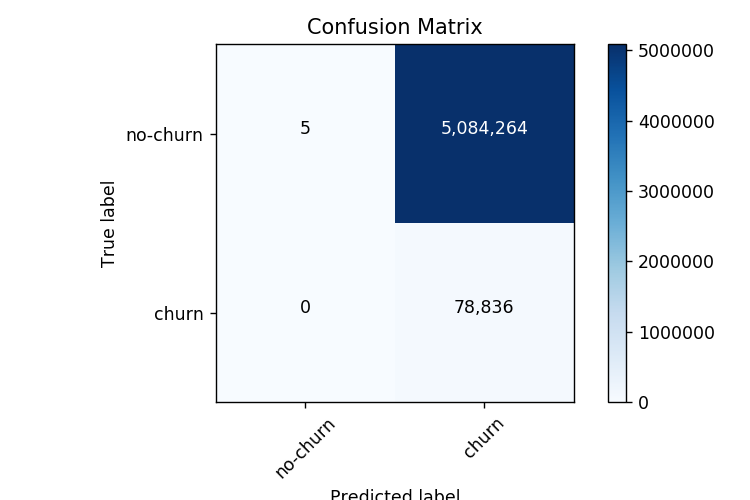

accuracy =  0.015270074887107661
misclass =  0.9847299251128924


In [43]:
plot_confusion_matrix(cm, normalize = False, target_names = ['no-churn', 'churn'], title = "Confusion Matrix")

## Random forest classifier

A random forest is a machine learning classification algorithm. Random forests are generated collections of decision trees.

In [49]:
from pyspark.ml.classification import RandomForestClassifier
from time import *

In [51]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
model_rf=rf.fit(assembled_train_set)
predict_train_rf=model_rf.transform(assembled_train_set)
predict_test_rf=model_rf.transform(assembled_test_set)
y_true_rf = predict_test_rf.select(['label']).collect()
y_pred_rf = predict_test_rf.select(['prediction']).collect()
cm_rf = confusion_matrix(y_true_rf, y_pred_rf)

<IPython.core.display.Javascript object>


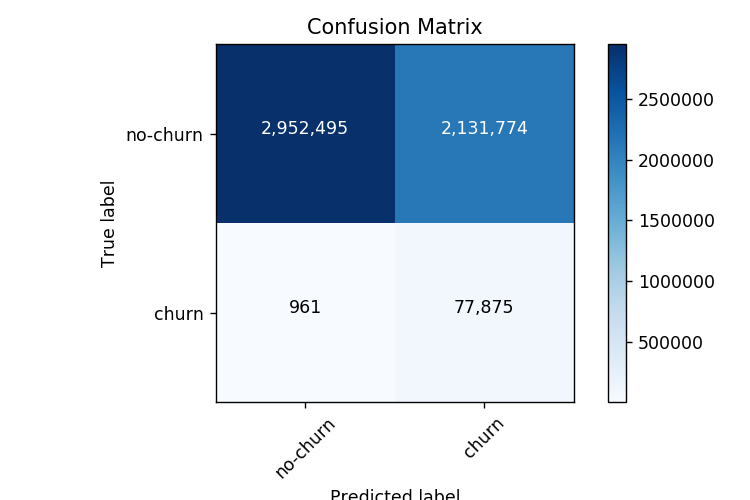

accuracy =  0.5869278273442047
misclass =  0.4130721726557953


In [52]:
plot_confusion_matrix(cm_rf, normalize = False, target_names = ['no-churn', 'churn'], title = "Confusion Matrix")

## Gradient-boosted tree classifier

In [53]:
gbt = GBTClassifier(labelCol='label', featuresCol="features", maxIter=50)
model_gbt=gbt.fit(assembled_train_set)
predict_train_gbt=model_gbt.transform(assembled_train_set)
predict_test_gbt=model_gbt.transform(assembled_test_set)
y_true_gbt = predict_test_gbt.select(['label']).collect()
y_pred_gbt = predict_test_gbt.select(['prediction']).collect()
cm_gbt = confusion_matrix(y_true_gbt, y_pred_gbt)

<IPython.core.display.Javascript object>


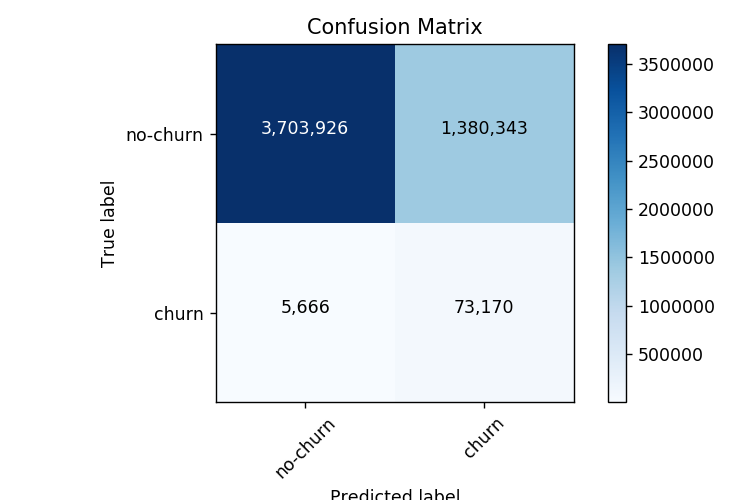

accuracy =  0.7315551397850711
misclass =  0.26844486021492886


In [55]:
plot_confusion_matrix(cm_gbt, normalize = False, target_names = ['no-churn', 'churn'], title = "Confusion Matrix")

## Decision tree classifier

In [57]:
from pyspark.ml.classification import DecisionTreeClassifier

In [58]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_dt=dt.fit(assembled_train_set)
predict_train_dt=model_dt.transform(assembled_train_set)
predict_test_dt=model_dt.transform(assembled_test_set)
y_true_dt = predict_test_dt.select(['label']).collect()
y_pred_dt = predict_test_dt.select(['prediction']).collect()
cm_dt = confusion_matrix(y_true_dt, y_pred_dt)

In [59]:
plot_confusion_matrix(cm_dt, normalize = False, target_names = ['no-churn', 'churn'], title = "Confusion Matrix")

<IPython.core.display.Javascript object>

accuracy =  0.49020831457039904
misclass =  0.509791685429601


## Linear Support Vector Machine

In [13]:
from pyspark.ml.classification import LinearSVC

In [ ]:
lsvc = LinearSVC(labelCol="label", featuresCol="features", maxIter=10, regParam=0.1)
model_lsvc=lsvc.fit(assembled_train_set)
predict_train_lsvc=model_lsvc.transform(assembled_train_set)
predict_test_lsvc=model_lsvc.transform(assembled_test_set)
y_true_lsvc = predict_test_lsvc.select(['label']).collect()
y_pred_lsvc = predict_test_lsvc.select(['prediction']).collect()
cm_lsvc = confusion_matrix(y_true_lsvc, y_pred_lsvc)

In [ ]:
plot_confusion_matrix(cm_lsvc, normalize = False, target_names = ['no-churn', 'churn'], title = "Confusion Matrix")

## Multilayer perceptron classifier

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [125, 125, 125, 2]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=1234)
model_mlp=trainer.fit(assembled_train_set)
predict_train_mlp=model_mlp.transform(assembled_train_set)
predict_test_mlp=model_mlp.transform(assembled_test_set)
y_true_mlp = predict_test_mlp.select(['label']).collect()
y_pred_mlp = predict_test_mlp.select(['prediction']).collect()
cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)